## Import Modules

In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

## 1. Data Preparation

In [15]:
# Load data
customers = pd.read_csv('Customers.csv', parse_dates=['SignupDate'])
transactions = pd.read_csv('Transactions.csv', parse_dates=['TransactionDate'])
products = pd.read_csv('Products.csv')

# Merge datasets
merged_data = (transactions.merge(customers, on='CustomerID')
    .merge(products, on='ProductID')
)

## 2. Feature Engineering

In [16]:
def create_clustering_features(df):
    """Create customer-level features for clustering"""
    
    # RFM Features
    snapshot_date = df['TransactionDate'].max() + pd.DateOffset(days=1)
    rfm = df.groupby('CustomerID').agg({
        'TransactionDate': lambda x: (snapshot_date - x.max()).days,
        'TransactionID': 'count',
        'TotalValue': 'sum'
    }).rename(columns={
        'TransactionDate': 'Recency',
        'TransactionID': 'Frequency',
        'TotalValue': 'Monetary'
    })
    
    # Product Category Preferences (Fixed Index Alignment Issue)
    category_counts = df.groupby(['CustomerID', 'Category']).size().unstack(fill_value=0)
    total_transactions = df.groupby('CustomerID').size()
    category_pct = category_counts.div(total_transactions, axis=0).add_prefix('CategoryPct_')
    
    # Purchase Patterns
    purchase_patterns = df.groupby('CustomerID').agg({
        'Quantity': ['mean', 'std'],
        'TransactionDate': lambda x: (x.max() - x.min()).days
    })
    purchase_patterns.columns = ['AvgQuantity', 'StdQuantity', 'PurchaseSpan']
    
    # Demographic Features
    demo_features = df[['CustomerID', 'Region', 'SignupDate']].drop_duplicates()
    demo_features['Tenure'] = (pd.to_datetime('today') - demo_features['SignupDate']).dt.days
    
    # Combine all features
    features = (
        rfm.merge(category_pct, on='CustomerID')
        .merge(purchase_patterns, on='CustomerID')
        .merge(demo_features, on='CustomerID')
    )
    
    return features.drop(columns='SignupDate')

cluster_data = create_clustering_features(merged_data)


## 3. Data Preprocessing

In [17]:
# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Recency', 'Frequency', 'Monetary', 'Tenure']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Region']),
        ('category_pct', 'passthrough', cluster_data.filter(regex='CategoryPct_').columns)
    ]
)

processed_data = preprocessor.fit_transform(cluster_data)

# 4. Determine Optimal Clusters
  Evaluate clusters from 2 to 10


In [18]:
cluster_range = range(2, 11)
db_scores = []
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(processed_data)
    
    db_scores.append(davies_bouldin_score(processed_data, labels))
    silhouette_scores.append(silhouette_score(processed_data, labels))

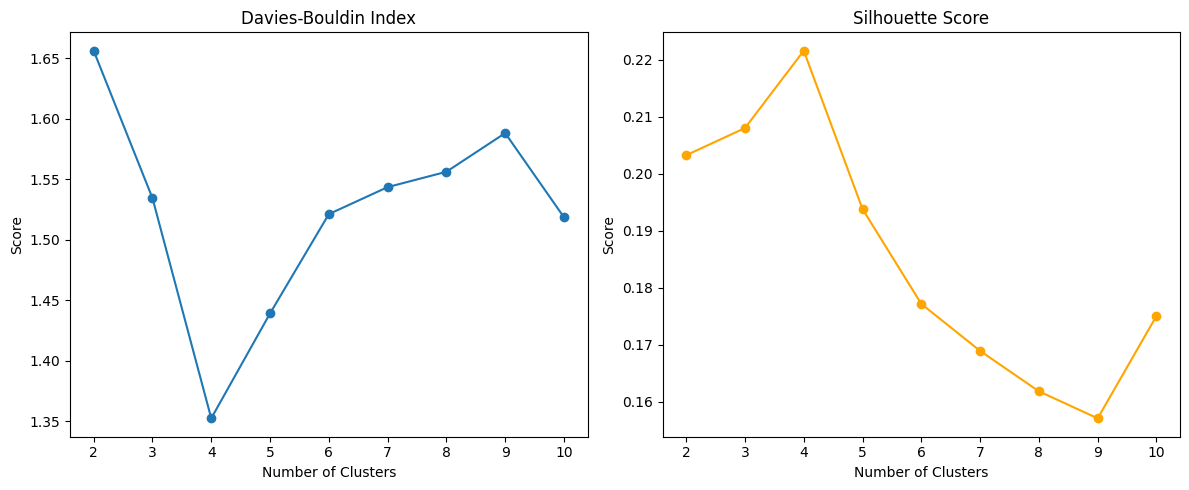

In [19]:

# Plot evaluation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

## 5. Final Clustering

In [20]:

optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(processed_data)



cluster_data['Cluster'] = cluster_labels # Add labels to oruiginal data

## 6. Cluster Analysis


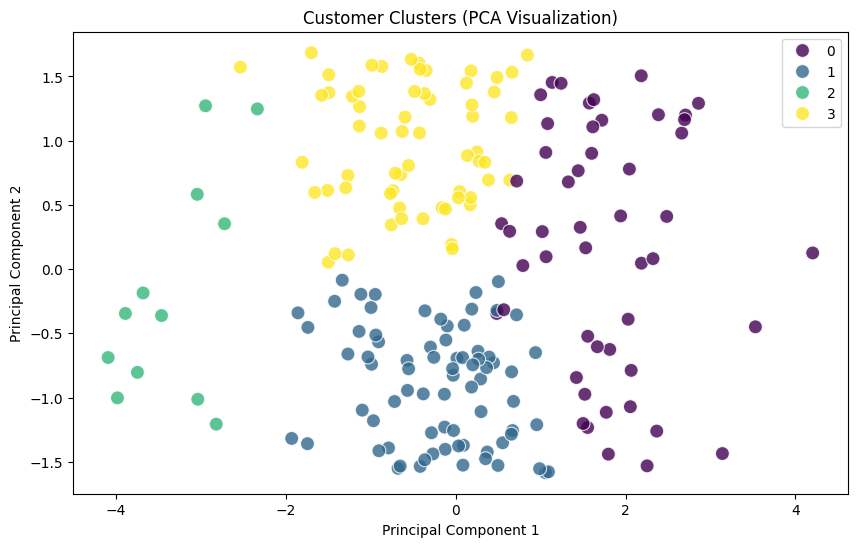

In [21]:

# PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(processed_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=principal_components[:,0], 
                y=principal_components[:,1],
                hue=cluster_labels,
                palette='viridis',
                s=100,
                alpha=0.8)
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()




In [22]:
# Cluster profile analysis
cluster_profile = (
    cluster_data.groupby('Cluster')
    .agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'Tenure': 'mean',
        'Region': lambda x: x.mode()[0],
        'CategoryPct_Electronics': 'mean'
    })
    .reset_index()
)

In [23]:
print("\n🔍 Cluster Profiles:")
print(cluster_profile.round(2))


🔍 Cluster Profiles:
   Cluster  Recency  Frequency  Monetary  Tenure         Region  \
0        0    45.48       7.66   5764.42  658.42  South America   
1        1    58.77       4.64   3078.16  267.36  North America   
2        2   275.92       1.33    764.80  419.83           Asia   
3        3    79.19       4.08   2608.64  862.19         Europe   

   CategoryPct_Electronics  
0                     0.27  
1                     0.25  
2                     0.17  
3                     0.24  


## 7. Results & Metrics


In [24]:
final_db_score = davies_bouldin_score(processed_data, cluster_labels)
final_silhouette = silhouette_score(processed_data, cluster_labels)

print(f"\n📊 Final Metrics:")
print(f"Davies-Bouldin Index: {final_db_score:.3f}")
print(f"Silhouette Score: {final_silhouette:.3f}")
print(f"Number of Clusters: {optimal_clusters}")


📊 Final Metrics:
Davies-Bouldin Index: 1.352
Silhouette Score: 0.222
Number of Clusters: 4
